In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.prune import BasePruningMethod

In [2]:
DATA_PATH = "./data/"
seed = 42
device = "cuda"

In [3]:
df =  pd.read_csv(DATA_PATH +  "train.csv")

In [4]:
y = df["label"].values
X = df.drop("label", axis=1).values
X = X.reshape((len(X), 1,  28, 28))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed)

In [5]:
class MNIST(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx, :, :, :], self.y[idx]

In [6]:
batch_size = 128
num_workers = 4

train_dataset = MNIST(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_dataset = MNIST(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [7]:
class BNLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_1 = BNLayer(in_channels, in_channels)
        self.conv_2 = BNLayer(in_channels, out_channels, stride=2)
    
    def forward(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        return x
    
class Net(nn.Module):
    def __init__(self, channels, num_classes=10):
        super().__init__()
        
        self.conv_blocks = []
        
        self.conv_blocks.append(BNLayer(1, channels[0], kernel_size=5))        
        for i in range(len(channels) - 1):
            self.conv_blocks.append(Block(channels[i], channels[i+1]))
        self.conv_blocks = nn.Sequential(*self.conv_blocks)
        
        self.linear = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = self.conv_blocks(x)
        x = F.adaptive_avg_pool2d(x, 1)
        x = x.view(len(x), -1)
        x = self.linear(x)
        return x

In [8]:
torch.manual_seed(seed)

channels = [8, 16, 32]
model = Net(channels).to(device)

In [9]:
num_epochs = 41
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fct = nn.CrossEntropyLoss()

In [10]:
def calculate_accuracy(y_pred, y_true):
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = torch.argmax(y_pred, dim=1)
    correct =  y_pred  == y_true
    return torch.mean(correct.float()).numpy()

def one_step(model,  optimizer):
    train_loss, val_loss =  0.0, 0.0    
    val_acc = 0.0
    
    model.train()
    for _, (x, y) in enumerate(train_dataloader):
        model.zero_grad()
        y, x  = y.to(device), x.to(device)
        
        y_hat = model(x)
        batch_loss = loss_fct(y_hat, y)
        batch_loss.backward()
        optimizer.step()
        
        train_loss += batch_loss.detach().cpu().numpy() / len(y)

    model.eval()
    for _, (x, y) in enumerate(val_dataloader):
        y, x  = y.to(device), x.to(device)
        y_hat = model(x)
        batch_loss = loss_fct(y_hat, y)
        val_loss += batch_loss.detach().cpu().numpy() / len(y)
        val_acc += calculate_accuracy(y_hat.detach().cpu(), y.cpu())
    
    train_loss = np.round(train_loss / len(train_dataloader), 6)
    val_loss = np.round(val_loss / len(val_dataloader), 6)
    val_acc = np.round(val_acc / len(val_dataloader), 6)
    
    return train_loss, val_loss, val_acc

In [11]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    train_loss, val_loss, val_acc = one_step(model, optimizer)
    
    if epoch % 5 == 0:
        print(f"-------- Epoch {epoch} --------")
        print(f"Train loss: {train_loss}")
        print(f"Val loss: {val_loss}")
        print(f"Val acc: {val_acc}")

-------- Epoch 0 --------
Train loss: 0.016908
Val loss: 0.015977
Val acc: 0.34977
-------- Epoch 5 --------
Train loss: 0.008611
Val loss: 0.007999
Val acc: 0.864741
-------- Epoch 10 --------
Train loss: 0.004498
Val loss: 0.004228
Val acc: 0.940893
-------- Epoch 15 --------
Train loss: 0.00263
Val loss: 0.002474
Val acc: 0.954568
-------- Epoch 20 --------
Train loss: 0.001761
Val loss: 0.0017
Val acc: 0.962561
-------- Epoch 25 --------
Train loss: 0.001303
Val loss: 0.001281
Val acc: 0.968401
-------- Epoch 30 --------
Train loss: 0.001032
Val loss: 0.001024
Val acc: 0.97229
-------- Epoch 35 --------
Train loss: 0.000861
Val loss: 0.000884
Val acc: 0.975289
-------- Epoch 40 --------
Train loss: 0.000738
Val loss: 0.000788
Val acc: 0.977645


In [12]:
class ThresholdPruning(BasePruningMethod):
    PRUNING_TYPE = "unstructured"

    def __init__(self, percentile_threshold,  type_):
        """
            Two types of pruning is supported:
                global - calculate one threshold value based on the conv layer.
                kernel - calculate threshold values per kernel (i.e. per 3x3 kernel)
        """

        if type(percentile_threshold) == float:
            percentile_threshold = percentile_threshold * 100
        self.percentile_threshold = percentile_threshold

        if type_ != "global" and type_ != "kernel":
            raise ValueError("Only global or kernel is supported")
        self.type_ = type_

    def compute_mask(self, t, default_mask):
        if self.type_  == "global":
            threshold = np.percentile(np.abs(t.detach().cpu().numpy()), self.percentile_threshold)
            mask = torch.abs(t) > threshold
        else:
            threshold = np.percentile(np.abs(t.detach().cpu().numpy()), self.percentile_threshold, axis=(2, 3))
            threshold = torch.from_numpy(threshold).unsqueeze(-1).unsqueeze(-1).to(device)
            mask = torch.abs(t) > threshold
        return mask

    @classmethod
    def apply(cls, module, name, percentile_threshold, type_):
        return super(ThresholdPruning, cls).apply(module, name, percentile_threshold, type_)

In [13]:
def prune_conv(model, amount, type_):
    for module in model.modules():
        if type(module) == nn.Conv2d:
            ThresholdPruning.apply(module, "weight", amount, type_)

In [14]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

global_prune_amount = [i  /  10 for i in range(1, 10)]
global_acc = []

for p in global_prune_amount:
    global_prune_model = deepcopy(model)
    prune_conv(global_prune_model, p, "global")
    prune_global_optimizer = optim.Adam(global_prune_model.parameters(), lr=lr)

    for epoch in range(5):
        _, _, val_acc = one_step(global_prune_model, prune_global_optimizer)
    global_acc.append(val_acc)

In [15]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

kernel_level_prune_amount = [i  /  10 for i in range(1, 10)]
kernel_level_acc = []

for p in kernel_level_prune_amount:
    kernel_prune_model = deepcopy(model)
    prune_conv(kernel_prune_model, p, "kernel")
    prune_kernel_optimizer = optim.Adam(kernel_prune_model.parameters(), lr=lr)

    for epoch in range(5):
        _, _, val_acc = one_step(kernel_prune_model, prune_kernel_optimizer)
    kernel_level_acc.append(val_acc)

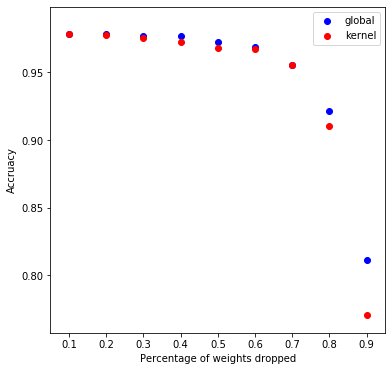

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(global_prune_amount, global_acc,  c="b", label="global")
plt.scatter(kernel_level_prune_amount, kernel_level_acc, c="r", label="kernel")
plt.xlabel("Percentage of weights dropped")
plt.ylabel("Accruacy")
plt.legend()
plt.show()